# **Курсовая работа**

## 1 Загрузка данных

In [1]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
# Функция для уменьшения объема требуемой памяти для хранения данных
# путем измененя типов данных
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [3]:
# Функция для расчета погрешностей предсказаний построенной модели

def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print(" Val  R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(8,4))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values/1000, y=train_true_values/1000)
    plt.xlabel('Predicted values / 1000')
    plt.ylabel('True values / 1000')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values/1000, y=test_true_values/1000)
    plt.xlabel('Predicted values / 1000')
    plt.ylabel('True values / 1000')
    plt.title('Val sample prediction')

    plt.show()

In [4]:
# Пути к файлам
# PATH = './input/real-estate-price-prediction-moscow/'
# TRAIN_DATASET_PATH = PATH + 'train.csv'
# TEST_DATASET_PATH = PATH + 'test.csv'
# SAMPLE_SUBMISSION_PATH = PATH + 'sample_submission.csv'

In [5]:
# Пути к файлам
TRAIN_DATASET_PATH =  './train.csv'
TEST_DATASET_PATH = './test.csv'
SAMPLE_SUBMISSION_PATH = './sample_submission.csv'

In [6]:
# Загрузка тренировочной выборки данных
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.tail(5)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.455796
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.148807
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.912580
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855
9999,7202,94,1.0,35.815476,22.301367,6.0,9,9.0,1975,0.127376,B,B,43,8429,3,NaN,3,9,B,177685.627486


In [7]:
# Просмотр типов данных каждого поля
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [8]:
# Уменьшение объема памяти
train_df = reduce_mem_usage(train_df)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%


In [9]:
train_df.dtypes

Id                  int16
DistrictId          int16
Rooms             float32
Square            float32
LifeSquare        float32
KitchenSquare     float32
Floor                int8
HouseFloor        float32
HouseYear           int32
Ecology_1         float32
Ecology_2        category
Ecology_3        category
Social_1             int8
Social_2            int16
Social_3            int16
Healthcare_1      float32
Helthcare_2          int8
Shops_1              int8
Shops_2          category
Price             float32
dtype: object

In [10]:
# Выполняем преобразование типа данных для поля 'Rooms' и 'HouseFloor'
train_df['Rooms'] = train_df['Rooms'].astype('int32')
train_df['HouseFloor'] = train_df['HouseFloor'].astype('int32')
train_df['DistrictId'] = train_df['DistrictId'].astype('str')

In [11]:
# Загрузка тестовой выборки данных
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.tail(5)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,10379,29,2.0,43.177521,30.339945,5.0,6,5.0,1962,0.069660,B,B,31,6119,4,NaN,1,2,B
4996,16138,38,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,B,B,15,2787,2,520.0,0,7,B
4997,3912,101,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,B,B,28,6533,1,1015.0,2,5,B
4998,5722,10,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,B,B,33,7976,5,NaN,0,11,B
4999,11004,21,2.0,67.122742,33.944344,13.0,9,17.0,2009,0.194489,B,B,47,8004,3,125.0,3,5,B


In [12]:
# Уменьшение объема памяти
test_df = reduce_mem_usage(test_df)

Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.22 MB
Decreased by 70.3%


In [13]:
# Выполняем преобразование типа данных для поля 'Rooms' и 'HouseFloor'
test_df['Rooms'] = test_df['Rooms'].astype('int32')
test_df['HouseFloor'] = test_df['HouseFloor'].astype('int32')
test_df['DistrictId'] = test_df['DistrictId'].astype('str')

## 2. Анализ данных и преобразование данных

In [14]:
# Класс для анализа и подготовки данных
class DataPipeline:
    """Подготовка исходных данных"""
    
    def __init__(self):
      self.medians = None

      self.KtchnSq_max_value=None
      self.KtchnSq_min_value=None

      self.Sq_max_value=None
      self.Sq_min_value=None

      self.LfSq_max_value=None
      self.LfSq_min_value=None

      self.med_add_places = None
     
      self.med_KSqByDis = None
      self.med_KSqByDis_median = None

      self.med_SqByDis = None
      self.med_SqByDis_median = None

      self.med_Health1ByDis = None


    def plots(self, df):
      """Построение графиков"""
      for col in df.columns:
        col_type = df[col].dtype.name

        if (col_type != 'category') and (col != 'Id') and (col != 'DistrictId'):
          plt.figure(figsize = (5, 2))
          # Вычисляем среднее значение и медиану для цены
          col_mean = round(df[col].mean(), 2)
          col_median = round(df[col].median(),2)
          col_mode = df[col].mode()[0]

          # Количество столбцов в гистограмме
          columns_num = int(np.floor(np.log2(df[col].size)))

          # Максимальное и минимальное плотность распределения
          # sns.kdeplot(train_df[col], shade=False, legend=False, color="black")
          x, y, _ = plt.hist(df[col], bins=columns_num)

          y = np.linspace(0, np.max(x), 10)
          plt.plot([col_mean] * 10, y, label='?',  linewidth=4, color="orange")
          plt.plot([col_median] * 10, y, label='?',  linewidth=4, color="red")
          plt.plot([col_mode] * 10, y, label='?',  linewidth=4, color="cyan")

          plt.ylabel('count')
          plt.xlabel(col)

          plt.title('Distribution of ' + col)
      
      correlation = df.corrwith(df['Price']).sort_values(ascending=False)
      correlation.drop('Price', inplace=True)

      plt.figure(figsize = (5, 2))
      plt.bar(correlation.index, correlation)
      plt.xticks(rotation='90')
      plt.xlabel('Features', fontsize=15)
      plt.ylabel('Correlation', fontsize=15)
      plt.title('Feature correlation', fontsize=15)
      plt.show()


    def fit(self, df):
      """Расчет статистических показателей"""
      # Расчет медианных значений
      self.medians = df.median()
      
      # Расчет предельных значений Square и KitchenSquare через квантили
      self.KtchnSq_max_value = np.quantile(df['KitchenSquare'], q=0.975)
      self.KtchnSq_min_value = np.quantile(df['KitchenSquare'], q=0.025)

      self.Sq_max_value = np.quantile(df['Square'], q=0.975)
      self.Sq_min_value = np.quantile(df['Square'], q=0.025)

      self.LfSq_max_value=np.quantile(df['LifeSquare'], q=0.975)
      self.LfSq_min_value=np.quantile(df['LifeSquare'], q=0.025)

      #медиана площадей нежилых помещений
      cond0 = df['LifeSquare'].notna()
      self.med_add_places = (df.loc[cond0, 'Square'] -\
                               df.loc[cond0, 'LifeSquare'] -\
                               df.loc[cond0, 'KitchenSquare']).median() 

      # Расчет медианных значений по районам
      data_in = df.copy()

      self.med_KSqByDis = data_in.groupby(['DistrictId'], as_index=False).\
                      agg({'KitchenSquare':'median'}).rename(columns={'KitchenSquare':'MedKSqByDis'})
      self.med_KSqByDis_median = self.med_KSqByDis['MedKSqByDis'].median()

      self.med_SqByDis = data_in.groupby(['DistrictId'], as_index=False).\
                        agg({'Square':'median'}).rename(columns={'Square':'MedSqByDis'})
      self.med_SqByDis_median = self.med_SqByDis['MedSqByDis'].median()

      # KitchenSquare < 3 заменим на медиану
      self.med_KSqByDis.loc[self.med_KSqByDis['MedKSqByDis']<3, 'MedKSqByDis'] = self.med_KSqByDis_median

      # Square < 10 заменим на медиану
      self.med_SqByDis.loc[self.med_SqByDis['MedSqByDis']<10, 'MedSqByDis'] = self.med_SqByDis_median


      self.med_Health1ByDis = data_in.loc[df['Healthcare_1'].notna()].groupby(['DistrictId'])['Healthcare_1'].agg('median').to_dict()


    def transform(self, df):
      """Преобразование данных"""
      data_tr = df.copy()
      

      # Заполняем отсутствующих данных в площадях LifeSquare, 'Healthcare_1'
      cond0 = data_tr['LifeSquare'].isna()
      data_tr.loc[cond0, 'LifeSquare'] =  0.75*data_tr.loc[cond0, 'Square'] - data_tr.loc[cond0, 'KitchenSquare']

      data_tr.loc[data_tr['LifeSquare']<0, 'LifeSquare'] = data_tr['LifeSquare'].median()

      data_tr.loc[data_tr['Healthcare_1'].isna(), 'Healthcare_1'] = data_tr['DistrictId'].map(self.med_Health1ByDis)
      data_tr.loc[data_tr['Healthcare_1'].isna(), 'Healthcare_1'] = np.mean(list(self.med_Health1ByDis.values()))

      # Обработка выбросов 
      # Новый признак, равный 1, если число комнат меньше 1 и больше 5

      data_tr['Rooms_out'] = 0
      cond0 = (data_tr['Rooms'] == 0) | (data_tr['Rooms'] > 5)
      data_tr.loc[cond0, 'Rooms_out'] = 1

      # Исправляем число комнат меньше 1 и больше 5 на медианное значение
      data_tr.loc[cond0, 'Rooms'] = self.medians['Rooms']  
      # data_tr.loc[data_tr['Rooms'] < 1, 'Rooms'] = 1
      # data_tr.loc[data_tr['Rooms'] > 5, 'Rooms'] = 5
      #Новый признак Square_outlier равный 1, если
      #LifeSquare + KitchenSquare превышают Square
      data_tr['Square_out']=0
      data_tr.loc[(data_tr['KitchenSquare']+data_tr['LifeSquare'])>data_tr['Square'] , 'Square_out'] = 1

      # Убираем значения площадей, которые превышают значения выбранных квантилей
      cond0 = (data_tr['KitchenSquare'].isna()) | (data_tr['KitchenSquare'] > self.KtchnSq_max_value) | \
                     (data_tr['KitchenSquare'] < self.KtchnSq_min_value)
      data_tr.loc[cond0, 'KitchenSquare'] = self.medians['KitchenSquare']

      cond0 = (data_tr['LifeSquare'].isna()) | (data_tr['LifeSquare'] > self.LfSq_max_value) | \
                     (data_tr['LifeSquare'] < self.LfSq_min_value)
      data_tr.loc[cond0, 'LifeSquare'] = self.medians['LifeSquare']

      cond0 = (data_tr['Square'].isna()) | (data_tr['Square'] > self.Sq_max_value) | \
                     (data_tr['Square'] < self.Sq_min_value)
      data_tr.loc[cond0, 'Square'] = self.medians['Square']

      #Если KitchenSquare <3  и Square <10, то заменим на медианное по району значение
      data_tr = data_tr.merge(self.med_KSqByDis, on=['DistrictId'], how='left')
      data_tr.loc[data_tr['KitchenSquare']<3, 'KitchenSquare'] = data_tr['MedKSqByDis']
      data_tr.drop('MedKSqByDis', axis=1, inplace=True)

      data_tr['KitchenSquare'].fillna(self.med_KSqByDis_median, inplace=True)

      data_tr = data_tr.merge(self.med_SqByDis, on=['DistrictId'], how='left')
      data_tr.loc[data_tr['Square']<10, 'Square'] = data_tr['MedSqByDis']
      data_tr.drop('MedSqByDis', axis=1, inplace=True)

      data_tr['Square'].fillna(self.med_SqByDis_median, inplace=True)

      # Исправляем значения площадей, если KitchenSquare + LifeSquare > Square
      cond0 = (data_tr['KitchenSquare'] + data_tr['LifeSquare']) > data_tr['Square']
      data_tr.loc[cond0, 'Square'] = data_tr['KitchenSquare'] + data_tr['LifeSquare']

      #Корректируем этажи
      #исключаем дома с нулевым кол-ом этажей

      data_tr['HouseFloor'], data_tr['Floor'] = np.where(data_tr['HouseFloor'] < data_tr['Floor'], 
                                                       (data_tr['Floor'], data_tr['HouseFloor']), 
                                                       (data_tr['HouseFloor'], data_tr['Floor']))

      data_tr.loc[data_tr['HouseFloor'] == 0 ,'HouseFloor'] = data_tr.loc[data_tr['HouseFloor'] == 0, 'Floor'] 
      
      #Если этаж квартиры равен нулю заменяем его случайным числом, меньшим чем кол-во этаже в доме
      cond0 = data_tr['Floor'] == 0
      data_tr.loc[cond0, 'Floor'] = data_tr.loc[cond0, 'HouseFloor'].apply(lambda x: random.randint(1, x))

      # Если HouseYear превышает 2020 год заменяем на 2020
      data_tr.loc[data_tr['HouseYear']>2020, 'HouseYear'] = 2020

      #Преобразуем категориальные переменные
      binary_to_numbers = {'A': 0, 'B': 1}
      data_tr['Ecology_2'] = data_tr['Ecology_2'].replace(binary_to_numbers)
      data_tr['Ecology_3'] = data_tr['Ecology_3'].replace(binary_to_numbers)
      data_tr['Shops_2'] = data_tr['Shops_2'].replace(binary_to_numbers)

      return data_tr

### 2.1 Анализ данных

In [15]:
train_df.describe()

,Id,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,1.890500,56.315720,37.199665,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214138.937500
std,4859.01902,0.839512,21.058716,86.241219,28.560839,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.519470,1.493601,4.806341,92872.273438
min,0.00000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,4169.50000,1.000000,41.774879,22.769833,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,8394.50000,2.000000,52.513309,32.781261,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,12592.50000,2.000000,65.900627,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,16798.00000,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


Наблюдается наличие некорректных данных в полях Rooms (min 0), Square (min 1 кв.м), KitchenSquare (min 0 кв. м), HouseFloor (min 0), HouseYear (max 2e7) 

In [16]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             10000 non-null  int16   
 1   DistrictId     10000 non-null  object  
 2   Rooms          10000 non-null  int32   
 3   Square         10000 non-null  float32 
 4   LifeSquare     7887 non-null   float32 
 5   KitchenSquare  10000 non-null  float32 
 6   Floor          10000 non-null  int8    
 7   HouseFloor     10000 non-null  int32   
 8   HouseYear      10000 non-null  int32   
 9   Ecology_1      10000 non-null  float32 
 10  Ecology_2      10000 non-null  category
 11  Ecology_3      10000 non-null  category
 12  Social_1       10000 non-null  int8    
 13  Social_2       10000 non-null  int16   
 14  Social_3       10000 non-null  int16   
 15  Healthcare_1   5202 non-null   float32 
 16  Helthcare_2    10000 non-null  int8    
 17  Shops_1        10000 non-null  i

Имеются пропуски в полях LifeSquare и KitchenSquare  

In [17]:
data_prep = DataPipeline()

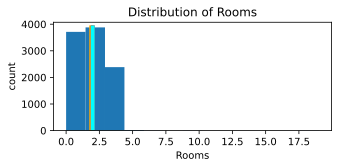

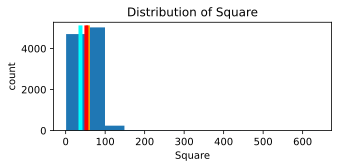

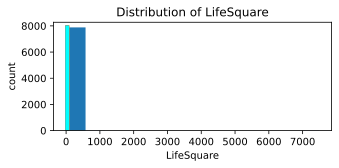

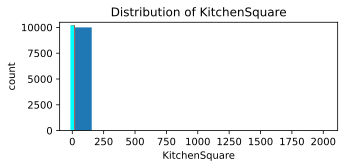

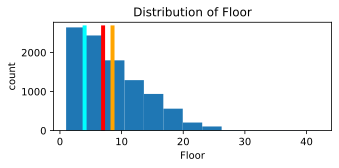

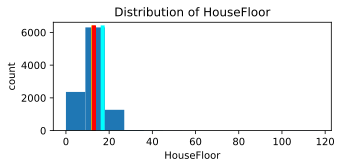

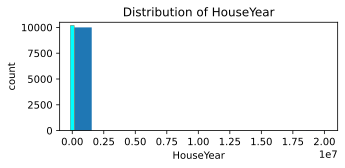

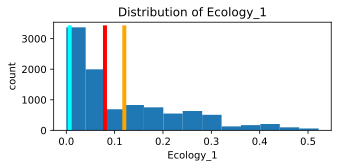

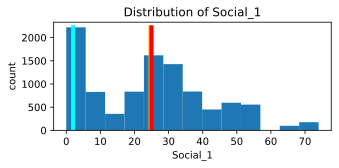

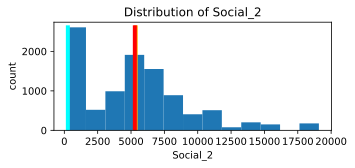

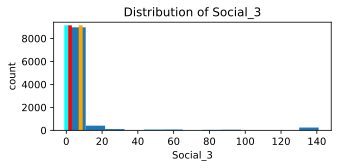

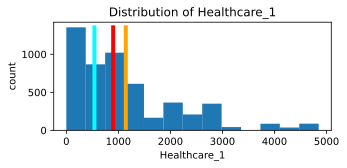

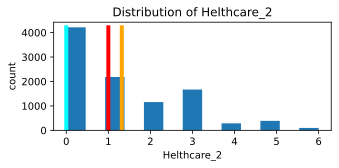

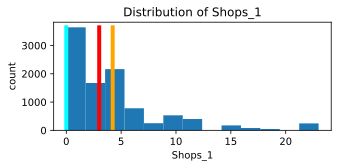

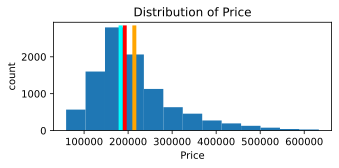

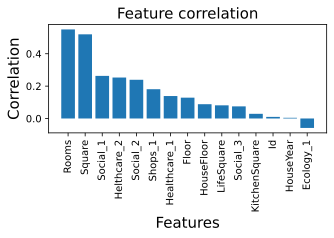

In [18]:
# Построение гистограмм для количественных признаков,
# и графика с корреляциями между признаками и ценой
data_prep.plots(train_df)

Наблюдаются выбросы в полях Square, LifeSquare, Kitchen, HouseYear

### 2.2 Обработка данных

In [19]:
# Определяем статистические показатели для данных
data_prep.fit(train_df)

In [20]:
# Преобразуем данные из тренировочной и тестовой выборки
train_df_tr = data_prep.transform(train_df)
test_df_tr = data_prep.transform(test_df)

In [21]:
train_df_tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int16  
 1   DistrictId     10000 non-null  object 
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float32
 4   LifeSquare     10000 non-null  float32
 5   KitchenSquare  10000 non-null  float32
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  int32  
 8   HouseYear      10000 non-null  int32  
 9   Ecology_1      10000 non-null  float32
 10  Ecology_2      10000 non-null  int64  
 11  Ecology_3      10000 non-null  int64  
 12  Social_1       10000 non-null  int8   
 13  Social_2       10000 non-null  int16  
 14  Social_3       10000 non-null  int16  
 15  Healthcare_1   10000 non-null  float32
 16  Helthcare_2    10000 non-null  int8   
 17  Shops_1        10000 non-null  int8   
 18  Shops_2

In [22]:
test_df_tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int16  
 1   DistrictId     5000 non-null   object 
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float32
 4   LifeSquare     5000 non-null   float32
 5   KitchenSquare  5000 non-null   float32
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   int32  
 8   HouseYear      5000 non-null   int16  
 9   Ecology_1      5000 non-null   float32
 10  Ecology_2      5000 non-null   int64  
 11  Ecology_3      5000 non-null   int64  
 12  Social_1       5000 non-null   int8   
 13  Social_2       5000 non-null   int16  
 14  Social_3       5000 non-null   int16  
 15  Healthcare_1   5000 non-null   float32
 16  Helthcare_2    5000 non-null   int8   
 17  Shops_1        5000 non-null   int8   
 18  Shops_2 

## 3 Добавление новых признаков

In [23]:
# Функции для построение нового признака col_name, 
# исходя из группировки данных по признаку col0 и 
# расчета медианного значения признака col
def compute_med_feature(col0, col, val_df):
  df = val_df.copy()
  col_name = 'Med' + col[0:3] + 'By' + col0[0:3]
  med_feature = df.groupby([col0], as_index=False).agg({col:'median'})\
                      .rename(columns={col: col_name})
  med_feature_median = med_feature[col_name].median()
  return med_feature, med_feature_median, col0, col_name

def add_med_feature(col0, col_name, med_feature, med_feature_median, val_df):
  df = val_df.copy()
  df = df.merge(med_feature, on=col0, how='left')
  df[col_name].fillna(med_feature_median, inplace=True)
  return df

In [24]:
# Функции для построение нового признака col_name, 
# исходя из группировки данных по признакам col0, col1 и 
# расчета медианного значения признака col
def compute_med_two_feature(col0, col1, col, val_df):
  df = val_df.copy()
  col_name = 'Med' + col[0:3] + 'By' + col0[0:3] + col1[0:3] + col1[-1]
  med_feature = df.groupby([col0, col1], as_index=False).agg({col:'median'})\
                      .rename(columns={col: col_name})
  med_feature_median = med_feature[col_name].median()
  return med_feature, med_feature_median, col0, col1, col_name

def add_med_two_feature(col0, col1, col_name, med_feature, med_feature_median, val_df):
  df = val_df.copy()

  df = df.merge(med_feature, on=[col0, col1], how='left')
  df[col_name].fillna(med_feature_median, inplace=True)
  return df

In [25]:
# Класс для создания новых признаков
class FeatureGenetator():
    """Генерация новых свойств"""

    def __init__(self):
        self.dict_ftr_one = None
        self.dict_ftr_two = None
        self.district_size = None
        self.district_mode = None

    def fit(self, df):
        data_ftr = df.copy()

        # DistrictSize - размер района
        self.district_size = data_ftr['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
        self.district_mode = data_ftr['DistrictId'].mode()[0]  

        if (self.dict_ftr_two is None):
          self.dict_ftr_two = {}
          

          data_ftr['PriceBySquare'] = data_ftr['Price'] / data_ftr['Square']

          comp_list = compute_med_two_feature('DistrictId', 'HouseYear', 'PriceBySquare', data_ftr)
          self.dict_ftr_two[comp_list[-1]] = comp_list[:-1]

          comp_list = compute_med_two_feature('DistrictId', 'Social_1', 'Price', data_ftr)
          self.dict_ftr_two[comp_list[-1]] = comp_list[:-1]

          comp_list = compute_med_two_feature('DistrictId', 'Social_2', 'Price', data_ftr)
          self.dict_ftr_two[comp_list[-1]] = comp_list[:-1]

          comp_list = compute_med_two_feature('DistrictId', 'Social_3', 'Price', data_ftr)
          self.dict_ftr_two[comp_list[-1]] = comp_list[:-1]


          comp_list = compute_med_two_feature('DistrictId', 'Healthcare_1', 'Price', data_ftr)
          self.dict_ftr_two[comp_list[-1]] = comp_list[:-1]

          comp_list = compute_med_two_feature('DistrictId', 'Shops_1', 'Price', data_ftr)
          self.dict_ftr_two[comp_list[-1]] = comp_list[:-1]

          comp_list = compute_med_two_feature('DistrictId', 'Shops_2', 'Price', data_ftr)
          self.dict_ftr_two[comp_list[-1]] = comp_list[:-1]

        #  Расчет признаков со средним значением LifeSquare, PriceBySquare,  Ecology_1 и Healthcare_1 по району
        if(self.dict_ftr_one is None):
          self.dict_ftr_one = {}
          comp_list = compute_med_feature('Rooms', 'LifeSquare', data_ftr)
          self.dict_ftr_one[comp_list[-1]] = comp_list[:-1]

          comp_list = compute_med_feature('DistrictId', 'PriceBySquare', data_ftr)
          self.dict_ftr_one[comp_list[-1]] = comp_list[:-1]

          comp_list = compute_med_feature('DistrictId', 'HouseYear', data_ftr)
          self.dict_ftr_one[comp_list[-1]] = comp_list[:-1]

          comp_list = compute_med_feature('DistrictId', 'Square', data_ftr)
          self.dict_ftr_one[comp_list[-1]] = comp_list[:-1]

          comp_list = compute_med_feature('DistrictId', 'Ecology_1', data_ftr)
          self.dict_ftr_one[comp_list[-1]] = comp_list[:-1]

          # comp_list = compute_med_feature('DistrictId', 'Healthcare_1', data_ftr)
          # self.dict_ftr_one[comp_list[-1]] = comp_list[:-1]
      
        data_ftr.drop(['PriceBySquare'], axis = 1, inplace = True)

    def feature_generation(self, df):
         data_ftr = df.copy()
        # Добавление признаков с медианной ценой за кв. м, исходя из района 
        # и года постройки дома / Social_1, 2, 3 / Shops_1  
         if (self.dict_ftr_two is not None):
           for col_ftr_name in self.dict_ftr_two:
             col_ftr, val_median_ftr, col0, col1 = self.dict_ftr_two[col_ftr_name]
             data_ftr = add_med_two_feature(col0, col1, col_ftr_name, col_ftr, val_median_ftr, data_ftr)
        
        #  Добавление признаков со средним значением Ecology_1 и Healthcare_1 по району
         if (self.dict_ftr_one is not None):
           for col_ftr_name in self.dict_ftr_one:
             col_ftr, val_median_ftr, col0 = self.dict_ftr_one[col_ftr_name]
             data_ftr = add_med_feature(col0, col_ftr_name, col_ftr, val_median_ftr, data_ftr)

        # Размер района  
         data_ftr = data_ftr.merge(self.district_size, on='DistrictId', how='left')
         data_ftr['DistrictSize'].fillna(self.district_mode, inplace=True)
         data_ftr['DistrictSize'] = data_ftr['DistrictSize'].astype('int64')

        # Раздлеяем все этажи на три категории - промежуточный, первый, последний
         cond0 = (data_ftr['Floor'] > 1) & (data_ftr['Floor'] < data_ftr['HouseFloor'])
         data_ftr.loc[cond0, 'Floor_cat'] = 1

         cond0 = (data_ftr['Floor'] == 1)
         data_ftr.loc[cond0, 'Floor_cat'] = 2

         cond0 = (data_ftr['Floor'] == data_ftr['HouseFloor'])
         data_ftr.loc[cond0, 'Floor_cat'] = 3


         # Признак, отделяющий квартиры с количеством комнат более 3
         data_ftr = self.room_to_cat(data_ftr)        
        
        # Признак, отделяющий квартиры с площадью кухни более 8
         data_ftr = self.kitchensize_to_cat(data_ftr)  

         return data_ftr



    def room_to_cat(self, X):
          X['Room_cat'] = 0

          X.loc[X['Rooms'] <= 3, 'Room_cat'] = 0  
          X.loc[X['Rooms'] > 3,  'Room_cat'] = 1
          return X
    
    def kitchensize_to_cat(self, X):
          X['KitchenSize_cat'] = 0
          X.loc[X['KitchenSquare'] > 8,  'KitchenSize_cat'] = 1
          return X




In [26]:
# Добавление новых признаков
data_ftr = FeatureGenetator()
data_ftr.fit(train_df_tr)

In [27]:
train_df_tr_ftr = data_ftr.feature_generation(train_df_tr)
test_df_tr_ftr = data_ftr.feature_generation(test_df_tr)

In [28]:
train_df_tr_ftr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 38 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               10000 non-null  int16  
 1   DistrictId       10000 non-null  object 
 2   Rooms            10000 non-null  float64
 3   Square           10000 non-null  float32
 4   LifeSquare       10000 non-null  float32
 5   KitchenSquare    10000 non-null  float32
 6   Floor            10000 non-null  int64  
 7   HouseFloor       10000 non-null  int32  
 8   HouseYear        10000 non-null  int32  
 9   Ecology_1        10000 non-null  float32
 10  Ecology_2        10000 non-null  int64  
 11  Ecology_3        10000 non-null  int64  
 12  Social_1         10000 non-null  int8   
 13  Social_2         10000 non-null  int16  
 14  Social_3         10000 non-null  int16  
 15  Healthcare_1     10000 non-null  float32
 16  Helthcare_2      10000 non-null  int8   
 17  Shops_1      

In [29]:
test_df_tr_ftr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 37 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               5000 non-null   int16  
 1   DistrictId       5000 non-null   object 
 2   Rooms            5000 non-null   float64
 3   Square           5000 non-null   float32
 4   LifeSquare       5000 non-null   float32
 5   KitchenSquare    5000 non-null   float32
 6   Floor            5000 non-null   int64  
 7   HouseFloor       5000 non-null   int32  
 8   HouseYear        5000 non-null   int16  
 9   Ecology_1        5000 non-null   float32
 10  Ecology_2        5000 non-null   int64  
 11  Ecology_3        5000 non-null   int64  
 12  Social_1         5000 non-null   int8   
 13  Social_2         5000 non-null   int16  
 14  Social_3         5000 non-null   int16  
 15  Healthcare_1     5000 non-null   float32
 16  Helthcare_2      5000 non-null   int8   
 17  Shops_1       

## 4 Обучение модели

### 4.1 Отбор признаков

In [30]:
train_df_tr_ftr.columns.to_list()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Rooms_out',
 'Square_out',
 'MedPriByDisHour',
 'MedPriByDisSoc1',
 'MedPriByDisSoc2',
 'MedPriByDisSoc3',
 'MedPriByDisHea1',
 'MedPriByDisSho1',
 'MedPriByDisSho2',
 'MedLifByRoo',
 'MedPriByDis',
 'MedHouByDis',
 'MedSquByDis',
 'MedEcoByDis',
 'DistrictSize',
 'Floor_cat',
 'Room_cat',
 'KitchenSize_cat']

In [31]:
# Отбор признаков
feature_names = [
                  # 'Id',
                  'DistrictId',
                  'Rooms',
                  'Square',
                  'LifeSquare',
                  'KitchenSquare',
                  'Floor',
                  'HouseFloor',
                  'HouseYear',
                  'Ecology_1',
                  'Ecology_2',
                  'Ecology_3',
                  'Social_1',
                  'Social_2',
                  'Social_3',
                  'Healthcare_1',
                  'Helthcare_2',
                  'Shops_1',
                  'Shops_2',
                  # 'Price',
                  # 'Rooms_out',
                  # 'Square_out',
                  # 'MedPriByDisHour',
                  # 'MedPriByDisSoc1',
                  # 'MedPriByDisSoc2',
                  # 'MedPriByDisSoc3',
                  'MedPriByDisHea1',
                  # 'MedPriByDisSho2',
                  'MedLifByRoo',
                  'MedPriByDis',
                  'MedHouByDis',
                  'MedSquByDis',
                  # 'MedEcoByDis',
                  'Floor_cat',
                  'DistrictSize',
                  'Room_cat',
                  'KitchenSize_cat'
                ]

target_name = 'Price'

### 4.2 Построение обучающей и валидационной выборки

In [32]:
# Разбиваем данные на обучающую и валидационную выборки
X = train_df_tr_ftr[feature_names]
y = train_df_tr_ftr[target_name]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=100)

In [33]:
X_train.head(5)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Shops_2,MedPriByDisHea1,MedLifByRoo,MedPriByDis,MedHouByDis,MedSquByDis,Floor_cat,DistrictSize,Room_cat,KitchenSize_cat
8369,9,3.0,66.698814,40.541031,8.0,4,12,1988,0.136244,1,...,1,186307.765625,48.033649,3171.021484,1990.0,57.393326,1.0,294,0,0
9722,6,3.0,82.790512,75.790512,7.0,17,17,2016,0.243205,1,...,1,168980.375000,48.033649,2793.693604,1977.0,61.280666,3.0,511,0,0
6950,61,2.0,49.242817,33.781868,6.0,6,9,1976,0.300323,1,...,1,222772.781250,33.949814,4528.020508,1980.0,52.370857,1.0,118,0,0
1919,25,3.0,90.392563,80.392563,10.0,15,17,2017,0.069753,1,...,1,254553.578125,48.033649,3990.096924,1999.0,61.874668,1.0,77,0,1
5713,44,1.0,52.513309,20.946671,7.0,3,14,1973,0.175055,1,...,1,202526.500000,22.719419,4472.750000,1977.0,48.086235,1.0,104,0,0


### 4.3 Построение и обучение модели 

In [34]:
# Построение модели GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor
gb_model = GradientBoostingRegressor(criterion='friedman_mse',
                                     max_depth=6,
                                     min_samples_leaf=50,
                                     random_state=100,  
                                     n_estimators=2250, 
                                     max_features='sqrt', 
                                     loss='huber', 
                                     learning_rate=0.025)

In [35]:
# Обучение модели
gb_model.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.025, loss='huber', max_depth=6,
                          max_features='sqrt', min_samples_leaf=50,
                          n_estimators=2250, random_state=100)

Train R2:	0.858
 Val  R2:	0.753


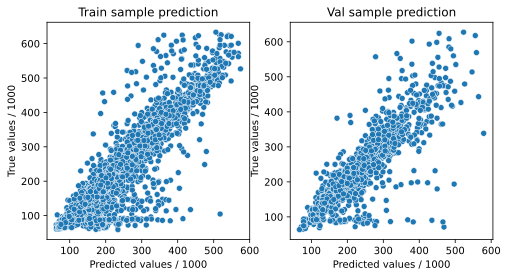

In [36]:
y_train_preds = gb_model.predict(X_train)
y_val_preds = gb_model.predict(X_val)

evaluate_preds(y_train, y_train_preds, y_val, y_val_preds)

In [37]:
# Кросс валидация
# cv_score = cross_val_score(gb_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=42))
# cv_score

In [38]:
# cv_score.mean()

### 4.4 Оценка важности признаков 

In [39]:
# Важность признаков
feature_importances = pd.DataFrame(zip(X_train.columns, gb_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
2,Square,1.934896e-01
18,MedPriByDisHea1,1.675753e-01
20,MedPriByDis,1.069386e-01
1,Rooms,9.678787e-02
19,MedLifByRoo,8.324165e-02
3,LifeSquare,7.529808e-02
24,DistrictSize,5.109359e-02
12,Social_2,3.655063e-02
11,Social_1,2.552431e-02
7,HouseYear,2.531434e-02


# 5. Прогноз на тестовой выборке данных

In [40]:
submit_price = pd.read_csv(SAMPLE_SUBMISSION_PATH)
submit_price.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [41]:
# Формирование тестовой выборки df, исходя из отобранных для обучения модели признаков
X_test = test_df_tr_ftr[feature_names]

In [42]:
# Расчет предсказаний на тестовом df
predictions = gb_model.predict(X_test)
predictions

array([162919.74886949, 117998.631593  , 138677.57839848, ...,
       153207.19352221, 190605.16977463, 301713.73364652])

In [43]:
# Сохранения предсказаний в файл
submit_price['Price'] = predictions
submit_price.to_csv('MZhelnin_predictions.csv', index=False)
submit_price.head(5)

,Id,Price
0,4567,162919.748869
1,5925,117998.631593
2,960,138677.578398
3,3848,99283.449676
4,746,167156.037518
